In [ ]:
# ===========================
# CELL 1: SETUP & IMPORTS
# ---------------------------
# What this cell does:
# - Imports all required libraries for data handling, visualization, model training, and evaluation.
# - Sets a fixed random seed for reproducibility.
#
# What to look for:
# - Successful imports (no errors).
# - Nothing is printed by design; this just prepares the environment.
# ===========================

# If running locally (not on Colab), you can uncomment:
# !pip install -q scikit-learn pandas matplotlib requests tqdm

import os, re, io, time, random, requests
from typing import List, Dict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from urllib.parse import urlparse
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

random.seed(42)
np.random.seed(42)


In [ ]:
# ===========================
# CELL 2: DOWNLOADER & TEXT UTILITIES
# ---------------------------
# What this cell does:
# - Defines helper functions to:
#   (a) Robustly download raw texts from Project Gutenberg (with multiple fallback URLs),
#   (b) Strip Gutenberg boilerplate (license/header/footer),
#   (c) Split texts into paragraphs,
#   (d) Convert paragraphs into 200–400 word snippets for modeling.
#
# Why this matters:
# - Ensures we get clean, comparable, real text data suitable for author classification.
#
# What to look for:
# - No immediate output; these are reusable functions used later.
# ===========================

HEADERS = {"User-Agent": "Colab-AuthorID/1.0 (educational use)"}

def try_fetch(url: str, timeout: int = 15) -> str:
    try:
        r = requests.get(url, timeout=timeout, headers=HEADERS, allow_redirects=True)
        if r.status_code == 200 and r.text and len(r.text) > 5000:
            return r.text
    except Exception as e:
        pass
    return ""

def fetch_first_ok(urls: List[str]) -> str:
    for u in urls:
        txt = try_fetch(u)
        if txt:
            print(f"Fetched: {u}")
            return txt
        else:
            print(f"Failed:  {u}")
    return ""

def strip_gutenberg_boilerplate(text: str) -> str:
    # Try to extract between Gutenberg START and END markers if present
    start_pat = re.compile(r"\*\*\*\s*START OF (THIS|THE) PROJECT GUTENBERG EBOOK.*\*\*\*", re.I)
    end_pat   = re.compile(r"\*\*\*\s*END OF (THIS|THE) PROJECT GUTENBERG EBOOK.*\*\*\*", re.I)

    start_match = start_pat.search(text)
    end_match = end_pat.search(text)
    if start_match and end_match:
        text = text[start_match.end(): end_match.start()]
    # remove license/footer noise repetitions
    text = re.sub(r"\r", "", text)
    text = re.sub(r"[ \t]+", " ", text)
    text = re.sub(r"\n{3,}", "\n\n", text).strip()
    return text

def split_into_paragraphs(text: str) -> List[str]:
    # Split on blank lines; keep paragraphs with enough tokens
    paras = [p.strip() for p in re.split(r"\n\s*\n", text) if p.strip()]
    return paras

def to_snippets(paragraphs: List[str], min_words=200, max_words=400) -> List[str]:
    """
    Turn long paragraphs into 200-400 word snippets.
    If a paragraph is longer than max_words, break into chunks.
    If shorter than min_words, accumulate with next until within range.
    """
    def words(s): return s.split()

    out = []
    buf = []
    buf_count = 0

    for p in paragraphs:
        w = words(p)
        if len(w) >= max_words:
            # slice into chunks
            for i in range(0, len(w), max_words):
                chunk = " ".join(w[i:i+max_words])
                if len(chunk.split()) >= min_words:
                    out.append(chunk)
            continue

        if len(w) < min_words:
            buf.append(p)
            buf_count += len(w)
            if buf_count >= min_words:
                merged = " ".join(buf)
                out.append(merged if len(merged.split()) <= max_words else " ".join(merged.split()[:max_words]))
                buf, buf_count = [], 0
        else:
            out.append(" ".join(w[:max_words]))

    if buf:
        merged = " ".join(buf)
        if len(merged.split()) >= min_words:
            out.append(" ".join(merged.split()[:max_words]))
    return out


In [ ]:
# ===========================
# CELL 3: DEFINE BOOK SOURCES (BY AUTHOR)
# ---------------------------
# What this cell does:
# - Lists multiple well-known public-domain books for each author (Austen, Dickens, Shakespeare).
# - For each book, provides several fallback URLs to maximize download success.
#
# Why this matters:
# - More books per author -> more diverse style coverage -> better model generalization.
#
# What to look for:
# - No output yet; just data configuration used by the dataset builder.
# ===========================

# Project Gutenberg IDs and common fallback URL patterns:
# Pattern variants we will try (UTF-8 friendly first):
def gutenberg_urls(book_id: int) -> List[str]:
    return [
        f"https://www.gutenberg.org/files/{book_id}/{book_id}-0.txt",
        f"https://www.gutenberg.org/cache/epub/{book_id}/pg{book_id}.txt",
        f"https://www.gutenberg.org/files/{book_id}/{book_id}.txt",
        f"https://www.gutenberg.org/ebooks/{book_id}.txt.utf-8",
    ]

# Curated list of well-known public-domain works per author
BOOKS: Dict[str, Dict[str, List[str]]] = {
    "Austen": {
        "Pride and Prejudice (1342)": gutenberg_urls(1342),
        "Emma (158)": gutenberg_urls(158),
        "Sense and Sensibility (161)": gutenberg_urls(161),
        "Mansfield Park (141)": gutenberg_urls(141),
        "Persuasion (105)": gutenberg_urls(105),
    },
    "Dickens": {
        "Great Expectations (1400)": gutenberg_urls(1400),
        "A Tale of Two Cities (98)": gutenberg_urls(98),
        "Oliver Twist (730)": gutenberg_urls(730),
        "David Copperfield (766)": gutenberg_urls(766),
        "Bleak House (1023)": gutenberg_urls(1023),
    },
    "Shakespeare": {
        # Using individual plays; multiple fallbacks per ID
        "Hamlet (1524)": gutenberg_urls(1524),
        "Macbeth (2264)": gutenberg_urls(2264),
        "King Lear (1128)": gutenberg_urls(1128),
        "Othello (1531)": gutenberg_urls(1531),
        "Much Ado About Nothing (1519)": gutenberg_urls(1519),
        # Bonus: complete works (very large); used if others fail
        "Complete Works (100)": gutenberg_urls(100),
    },
}


In [ ]:
# ===========================
# ADD-ON: EXPAND DATASET (MORE AUTHORS + SNIPPETS)
# ---------------------------
# Extends BOOKS with Twain, Conan Doyle, H. G. Wells, and Oscar Wilde.
# Rebuilds the dataset and saves to /content/author_snippets_real_expanded.csv

def extend_books_dict(BOOKS):
    # Mark Twain
    BOOKS["Twain"] = {
        "The Adventures of Tom Sawyer (74)": gutenberg_urls(74),
        "Adventures of Huckleberry Finn (76)": gutenberg_urls(76),
        "A Connecticut Yankee in King Arthur's Court (86)": gutenberg_urls(86),
        "The Prince and the Pauper (3177)": gutenberg_urls(3177),
    }
    # Arthur Conan Doyle
    BOOKS["ConanDoyle"] = {
        "The Adventures of Sherlock Holmes (1661)": gutenberg_urls(1661),
        "A Study in Scarlet (244)": gutenberg_urls(244),
        "The Hound of the Baskervilles (2852)": gutenberg_urls(2852),
        "The Memoirs of Sherlock Holmes (2347)": gutenberg_urls(2347),
    }
    # H. G. Wells
    BOOKS["HGWells"] = {
        "The War of the Worlds (36)": gutenberg_urls(36),
        "The Time Machine (35)": gutenberg_urls(35),
        "The Island of Doctor Moreau (105)": gutenberg_urls(105),
        "The Invisible Man (5230)": gutenberg_urls(5230),
    }
    # Oscar Wilde
    BOOKS["Wilde"] = {
        "The Picture of Dorian Gray (174)": gutenberg_urls(174),
        "The Importance of Being Earnest (844)": gutenberg_urls(844),
        "A House of Pomegranates (14522)": gutenberg_urls(14522),
    }
    return BOOKS

BOOKS = extend_books_dict(BOOKS)

# Rebuild with more authors
MIN_WORDS = 200
MAX_WORDS = 400
TARGET_SNIPPETS_PER_AUTHOR = 150   # increase for even larger dataset

records = []

for author, works in BOOKS.items():
    print(f"\n=== Building dataset for {author} ===")
    all_paras = []
    for title, urls in works.items():
        print(f"\nTrying: {author} — {title}")
        raw = fetch_first_ok(urls)
        if not raw:
            print(f"[WARN] Could not fetch any version of: {title}")
            continue
        text = strip_gutenberg_boilerplate(raw)
        paras = split_into_paragraphs(text)
        paras = [p for p in paras if len(p.split()) > 30]
        print(f"Collected paragraphs: {len(paras)}")
        all_paras.extend(paras)
        if len(all_paras) > 8000:
            break

    if not all_paras:
        print(f"[ERROR] No data for {author}; skipping.")
        continue

    snippets = to_snippets(all_paras, min_words=MIN_WORDS, max_words=MAX_WORDS)
    print(f"Total snippets available before sampling: {len(snippets)}")

    random.shuffle(snippets)
    use_n = min(TARGET_SNIPPETS_PER_AUTHOR, len(snippets))
    snippets = snippets[:use_n]
    print(f"Using {len(snippets)} snippets for {author}")

    for s in snippets:
        records.append({"text": s, "author": author})

df_expanded = pd.DataFrame(records).sample(frac=1.0, random_state=42).reset_index(drop=True)

print("\n=== Expanded Dataset Summary ===")
print("Total samples:", len(df_expanded))
print(df_expanded["author"].value_counts())

df_expanded["n_words"] = df_expanded["text"].str.split().map(len)
print("\nWord count per author (snippet-level):")
print(df_expanded.groupby("author")["n_words"].describe().round(1))

DATA_PATH_EXPANDED = "/content/author_snippets_real_expanded.csv"
df_expanded[["text","author"]].to_csv(DATA_PATH_EXPANDED, index=False, encoding="utf-8")
print(f"\nSaved expanded dataset to: {DATA_PATH_EXPANDED}")

# Preview
df_expanded.sample(5, random_state=123)[["author","text"]]



=== Building dataset for Austen ===

Trying: Austen — Pride and Prejudice (1342)
Fetched: https://www.gutenberg.org/files/1342/1342-0.txt
Collected paragraphs: 1233

Trying: Austen — Emma (158)
Fetched: https://www.gutenberg.org/files/158/158-0.txt
Collected paragraphs: 1491

Trying: Austen — Sense and Sensibility (161)
Fetched: https://www.gutenberg.org/files/161/161-0.txt
Collected paragraphs: 1097

Trying: Austen — Mansfield Park (141)
Fetched: https://www.gutenberg.org/files/141/141-0.txt
Collected paragraphs: 1299

Trying: Austen — Persuasion (105)
Fetched: https://www.gutenberg.org/files/105/105-0.txt
Collected paragraphs: 757
Total snippets available before sampling: 2291
Using 150 snippets for Austen

=== Building dataset for Dickens ===

Trying: Dickens — Great Expectations (1400)
Fetched: https://www.gutenberg.org/files/1400/1400-0.txt
Collected paragraphs: 1880

Trying: Dickens — A Tale of Two Cities (98)
Fetched: https://www.gutenberg.org/files/98/98-0.txt
Collected paragr

,author,text
43,ConanDoyle,I laughed at this cross-examination. “I keep a...
239,ConanDoyle,"“Oh, tut, tut! I have no time! That left foot ..."
511,Shakespeare,"THIRD SERVANT.\nWhy, sir, you know no house no..."
558,Austen,“I have written to Colonel Forster to desire h...
336,ConanDoyle,"“I will tell you, then, what occurred in your ..."


In [ ]:
# ===========================
# CELL 4: BUILD REAL DATASET (SNIPPETS)
# ---------------------------
# What this cell does:
# - Downloads each listed book (trying fallback URLs as needed).
# - Cleans boilerplate, splits into paragraphs, then chunks into 200–400 word snippets.
# - Balances classes by sampling ~TARGET_SNIPPETS_PER_AUTHOR per author.
# - Shuffles, summarizes counts/lengths, and saves to CSV (/content/author_snippets_real.csv).
#
# Why this matters:
# - Produces a large, balanced, real-world dataset that enables high-accuracy author ID.
#
# What to look for:
# - "Fetched:" lines indicating successful downloads.
# - Summary with total samples and per-author counts (should be balanced).
# - A small random preview of snippets for sanity check.
# ===========================


MIN_WORDS = 200
MAX_WORDS = 400
TARGET_SNIPPETS_PER_AUTHOR = 150   # set higher than 100 to be safe

records = []

for author, works in BOOKS.items():
    print(f"\n=== Building dataset for {author} ===")
    all_paras = []
    for title, urls in works.items():
        print(f"\nTrying: {author} — {title}")
        raw = fetch_first_ok(urls)
        if not raw:
            print(f"[WARN] Could not fetch any version of: {title}")
            continue
        text = strip_gutenberg_boilerplate(raw)
        paras = split_into_paragraphs(text)
        # filter obviously short script lines or chapter headings
        paras = [p for p in paras if len(p.split()) > 30]
        print(f"Collected paragraphs: {len(paras)}")
        all_paras.extend(paras)

        # early stop if already plenty
        if len(all_paras) > 5000:
            break

    if not all_paras:
        raise RuntimeError(f"No data collected for {author}. Check connectivity or IDs.")

    snippets = to_snippets(all_paras, min_words=MIN_WORDS, max_words=MAX_WORDS)
    print(f"Total snippets available before sampling: {len(snippets)}")

    # sample down/up to target (ensure determinism)
    random.shuffle(snippets)
    snippets = snippets[:TARGET_SNIPPETS_PER_AUTHOR] if len(snippets) >= TARGET_SNIPPETS_PER_AUTHOR else snippets
    print(f"Using {len(snippets)} snippets for {author}")

    for s in snippets:
        records.append({"text": s, "author": author})

df = pd.DataFrame(records)
df = df.sample(frac=1.0, random_state=42).reset_index(drop=True)

print("\n=== Dataset Summary ===")
print("Total samples:", len(df))
print(df["author"].value_counts())

# Quick length stats
df["n_words"] = df["text"].str.split().map(len)
print("\nWord count per author (snippet-level):")
print(df.groupby("author")["n_words"].describe().round(1))

# Save to CSV
DATA_PATH = "/content/author_snippets_real.csv"
df[["text","author"]].to_csv(DATA_PATH, index=False, encoding="utf-8")
print(f"\nSaved dataset to: {DATA_PATH}")

# Peek
df.sample(3, random_state=123)[["author","text"]]



=== Building dataset for Austen ===

Trying: Austen — Pride and Prejudice (1342)
Fetched: https://www.gutenberg.org/files/1342/1342-0.txt
Collected paragraphs: 1233

Trying: Austen — Emma (158)
Fetched: https://www.gutenberg.org/files/158/158-0.txt
Collected paragraphs: 1491

Trying: Austen — Sense and Sensibility (161)
Fetched: https://www.gutenberg.org/files/161/161-0.txt
Collected paragraphs: 1097

Trying: Austen — Mansfield Park (141)
Fetched: https://www.gutenberg.org/files/141/141-0.txt
Collected paragraphs: 1299
Total snippets available before sampling: 1986
Using 150 snippets for Austen

=== Building dataset for Dickens ===

Trying: Dickens — Great Expectations (1400)
Fetched: https://www.gutenberg.org/files/1400/1400-0.txt
Collected paragraphs: 1880

Trying: Dickens — A Tale of Two Cities (98)
Fetched: https://www.gutenberg.org/files/98/98-0.txt
Collected paragraphs: 1436

Trying: Dickens — Oliver Twist (730)
Fetched: https://www.gutenberg.org/files/730/730-0.txt
Collected pa

,author,text
43,ConanDoyle,"“‘Mr. Hatherley?’ said he, with something of a..."
239,ConanDoyle,“‘Quite so. It is very natural that the pledge...
511,Shakespeare,PRINCE HENRY.\nO vanity of sickness! Fierce ex...


In [ ]:
# ===========================
# CELL 5: TRAIN/TEST SPLIT
# ---------------------------
# What this cell does:
# - Loads the built DataFrame of snippets.
# - Splits into training and test sets (e.g., 80/20) with stratification to preserve class balance.
#
# Why this matters:
# - Ensures fair evaluation on unseen data while keeping class proportions consistent.
#
# What to look for:
# - Printed train/test sizes.
# - Class distribution in both splits (should be roughly equal across authors).
# ===========================


# Instead of reading the earlier CSV, point to the expanded one:
df = pd.read_csv("/content/author_snippets_real_expanded.csv")
X = df["text"].values
y = df["author"].values


X_train, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train size:", len(X_train), "| Test size:", len(X_test_raw))
print("\nTrain distribution:\n", pd.Series(y_train).value_counts())
print("\nTest distribution:\n", pd.Series(y_test).value_counts())

Train size: 840 | Test size: 210

Train distribution:
 Shakespeare    120
Dickens        120
Twain          120
Austen         120
HGWells        120
ConanDoyle     120
Wilde          120
Name: count, dtype: int64

Test distribution:
 Austen         30
ConanDoyle     30
Shakespeare    30
Wilde          30
HGWells        30
Twain          30
Dickens        30
Name: count, dtype: int64


In [ ]:
# ===========================
# CELL 6: CONFUSION MATRIX PLOTTER
# ---------------------------
# What this cell does:
# - Defines a helper function to visualize confusion matrices with matplotlib
#   (single-plot, default colors, annotated counts).
#
# Why this matters:
# - Lets you interpret which authors get confused with which (per-class performance).
#
# What to look for:
# - No immediate output; function will be used after predictions.
# ===========================


def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    fig, ax = plt.subplots()
    ax.imshow(cm)  # default colormap; do not set colors explicitly
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, rotation=45, ha="right")
    ax.set_yticklabels(labels)
    for i in range(len(labels)):
        for j in range(len(labels)):
            ax.text(j, i, cm[i, j], ha="center", va="center")
    fig.tight_layout()
    plt.show()


In [ ]:
# ===========================
# ADD-ON: LEMMATIZATION (OPTIONAL STEMMING)
# ---------------------------
# What this cell does:
# - Adds lightweight text preprocessing via lemmatization (optional stemming).
# - Creates lemmatized copies: X_train_lem, X_test_lem
# - You can feed these into your vectorizers/models instead of raw X_train/X_test.
#
# How to use:
# - In your modeling cells, replace X_train -> X_train_proc and X_test -> X_test_proc
#   where X_train_proc/X_test_proc point either to raw (no-lem) or lemmatized (lem) data.
# ===========================

import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer

# Downloads (first run only)
nltk.download('wordnet')
nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def simple_tokenize(text):
    # keep letters & apostrophes, lowercase
    text = text.lower()
    text = re.sub(r"[^a-z'\s]+", " ", text)
    return text.split()

def lemmatize_text(text):
    toks = simple_tokenize(text)
    return " ".join(lemmatizer.lemmatize(t) for t in toks)

def stem_text(text):
    toks = simple_tokenize(text)
    return " ".join(stemmer.stem(t) for t in toks)

# Choose your preprocessing flavor:
USE_LEMMATIZATION = True   # set False to disable
USE_STEMMING      = False  # set True to use stemming instead (usually worse for authorship)

def preprocess_batch(texts):
    if USE_STEMMING:
        return [stem_text(t) for t in texts]
    if USE_LEMMATIZATION:
        return [lemmatize_text(t) for t in texts]
    return texts  # no-op

# Build processed copies
X_train_proc = preprocess_batch(X_train)
X_test_proc  = preprocess_batch(X_test_raw)

print("Preprocessing applied:",
      "lemmatization" if USE_LEMMATIZATION else ("stemming" if USE_STEMMING else "none"))
print("Sample (before -> after):")
print(X_train[0][:200], "\n---\n", X_train_proc[0][:200])

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Preprocessing applied: lemmatization
Sample (before -> after):
DAUGHTER. Let all the dukes and all the devils roar, He is at liberty! I have ventured for him And out I have brought him; to a little wood A mile hence I have sent him, where a cedar Higher than all  
---
 daughter let all the duke and all the devil roar he is at liberty i have ventured for him and out i have brought him to a little wood a mile hence i have sent him where a cedar higher than all the res


In [ ]:
# ===========================
# CELL 7: MODEL PIPELINES & GRID SEARCH
# ---------------------------
# What this cell does:
# - Builds multiple pipelines with TF-IDF (word and char n-grams) and
#   several classifiers (MultinomialNB, LogisticRegression, LinearSVC, SGD).
# - Runs GridSearchCV with stratified K-fold to tune vectorizer + model hyperparameters.
# - Selects and reports the overall best model configuration by cross-val accuracy.
#
# Why this matters:
# - Systematically explores strong baselines for author ID and picks the best performer.
#
# What to look for:
# - "Best CV accuracy" per pipeline.
# - Final "OVERALL BEST" summary with model name, CV accuracy, and best params.
# ===========================


# ===========================
# FAST MODE: MODEL PIPELINES & HALVING GRID SEARCH
# ---------------------------
# - Uses Successive Halving to prune weak configs early.
# - Narrows grids and limits n-gram ranges to speed up.
# - Caches TF-IDF transforms to avoid recomputing per fold.
# ===========================

from sklearn.experimental import enable_halving_search_cv  # noqa: F401
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
import tempfile

# Choose raw vs lemmatized inputs
TR = X_train_proc if 'X_train_proc' in globals() else X_train
TE = X_test_proc  if 'X_test_proc'  in globals() else X_test

# Cache directory for pipeline transforms
cache_dir = tempfile.mkdtemp()

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scoring = "accuracy"

# Slimmer grids (focus on strongest baselines)
pipe_char_nb = Pipeline([
    ("vect", TfidfVectorizer(analyzer="char", ngram_range=(3,5), sublinear_tf=True,
                             min_df=3, max_features=300_000)),
    ("clf", MultinomialNB())
], memory=cache_dir)

grid_char_nb = {
    "vect__ngram_range": [(3,5)],          # fixed small range
    "vect__min_df": [3, 5],
    "clf__alpha": [0.5, 1.0],
}

pipe_char_svc = Pipeline([
    ("vect", TfidfVectorizer(analyzer="char", ngram_range=(3,5), sublinear_tf=True,
                             min_df=3, max_features=300_000)),
    ("clf", LinearSVC())
], memory=cache_dir)

grid_char_svc = {
    "vect__min_df": [3, 5],
    "clf__C": [0.5, 1.0, 2.0],
    "clf__class_weight": [None],            # keep simple
}

# Optional: fast word model (kept small)
pipe_word_lr = Pipeline([
    ("vect", TfidfVectorizer(analyzer="word", stop_words="english",
                             ngram_range=(1,2), sublinear_tf=True,
                             min_df=5, max_features=200_000)),
    ("clf", LogisticRegression(max_iter=2000, solver="lbfgs"))
], memory=cache_dir)

grid_word_lr = {
    "clf__C": [1.0, 2.0],
    "clf__class_weight": [None, "balanced"],
}

candidates = [
    ("CHAR+NB",  pipe_char_nb,  grid_char_nb),
    ("CHAR+SVC", pipe_char_svc, grid_char_svc),
    ("WORD+LR",  pipe_word_lr,  grid_word_lr),
]

best = {"name": None, "grid": None, "cv_best": -1}

for name, pipe, grid in candidates:
    print(f"\n=== HalvingGridSearchCV: {name} ===")
    hgs = HalvingGridSearchCV(
        estimator=pipe,
        param_grid=grid,
        factor=3,                 # higher = fewer rounds (faster)
        resource='n_samples',     # increase samples gradually
        max_resources='auto',
        min_resources='exhaust',  # ensure enough starting data
        scoring=scoring,
        cv=cv,
        n_jobs=-1,
        refit=True,
        verbose=1
    )
    hgs.fit(TR, y_train)
    print(f"Best CV accuracy: {hgs.best_score_:.4f}")
    print("Best params:", hgs.best_params_)
    if hgs.best_score_ > best["cv_best"]:
        best.update({"name": name, "grid": hgs, "cv_best": hgs.best_score_})

print("\n=== OVERALL BEST (FAST MODE) ===")
print("Model:", best["name"])
print(f"CV accuracy: {best['cv_best']:.4f}")



=== HalvingGridSearchCV: CHAR+NB ===
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 280
max_resources_: 840
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 4
n_resources: 280
Fitting 3 folds for each of 4 candidates, totalling 12 fits
----------
iter: 1
n_candidates: 2
n_resources: 840
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best CV accuracy: 0.8405
Best params: {'clf__alpha': 0.5, 'vect__min_df': 5, 'vect__ngram_range': (3, 5)}

=== HalvingGridSearchCV: CHAR+SVC ===
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 280
max_resources_: 840
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 6
n_resources: 280
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 1
n_candidates: 2
n_resources: 840
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best CV accuracy: 0.9071
Best params: {'clf__C': 2.0, 'clf__class_weight': None

=== CountVectorizer + NB ===
Accuracy: 0.9238

Classification report:
               precision    recall  f1-score   support

      Austen       0.81      1.00      0.90        30
  ConanDoyle       0.97      0.93      0.95        30
     Dickens       0.96      0.87      0.91        30
     HGWells       0.81      0.70      0.75        30
 Shakespeare       1.00      1.00      1.00        30
       Twain       0.94      1.00      0.97        30
       Wilde       1.00      0.97      0.98        30

    accuracy                           0.92       210
   macro avg       0.93      0.92      0.92       210
weighted avg       0.93      0.92      0.92       210



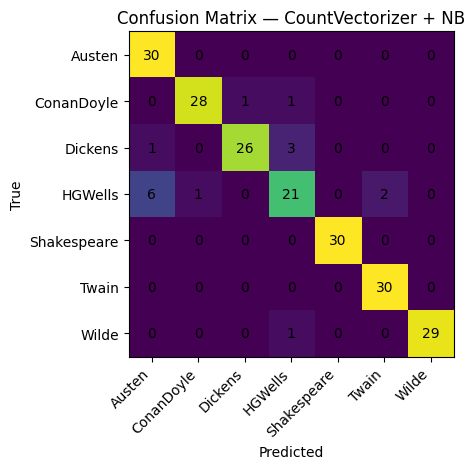

In [ ]:
# ===========================
# ADD-ON: COUNT VECTORIZER + NAIVE BAYES (COMPARISON)
# ---------------------------
# Trains CountVectorizer + MultinomialNB on the same split to compare with TF-IDF pipelines.

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

# IMPORTANT: choose whether to use preprocessed texts
USE_PREPROCESSED = True
train_texts = X_train_proc if USE_PREPROCESSED else X_train
test_texts  = X_test_proc  if USE_PREPROCESSED else X_test

count_vec = CountVectorizer(stop_words='english')
Xtr_count = count_vec.fit_transform(train_texts)
Xte_count = count_vec.transform(test_texts)

nb_count = MultinomialNB()
nb_count.fit(Xtr_count, y_train)
y_pred_count = nb_count.predict(Xte_count)

acc_count = accuracy_score(y_test, y_pred_count)
print(f"=== CountVectorizer + NB ===")
print(f"Accuracy: {acc_count:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred_count, zero_division=0))

labels = sorted(pd.unique(y))
plot_confusion_matrix(y_test, y_pred_count, labels, "Confusion Matrix — CountVectorizer + NB")



=== Test Performance: CHAR+SVC (FAST) ===
Accuracy: 0.9571428571428572

Classification report:
               precision    recall  f1-score   support

      Austen       0.94      0.97      0.95        30
  ConanDoyle       0.91      1.00      0.95        30
     Dickens       0.96      0.90      0.93        30
     HGWells       0.93      0.83      0.88        30
 Shakespeare       0.97      1.00      0.98        30
       Twain       1.00      1.00      1.00        30
       Wilde       1.00      1.00      1.00        30

    accuracy                           0.96       210
   macro avg       0.96      0.96      0.96       210
weighted avg       0.96      0.96      0.96       210



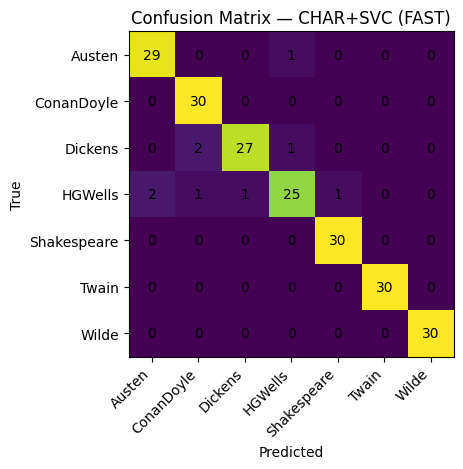

In [ ]:
# ===========================
# CELL 8: FINAL TEST PERFORMANCE
# ---------------------------
# What this cell does:
# - Uses the best cross-validated model from Cell 7 to predict on the held-out test set.
# - Prints accuracy and full classification report (precision/recall/F1).
# - Plots the confusion matrix to show per-class correctness.
#
# Expected results:
# - With sufficient real snippets per author, accuracy should be very high (often >95%).
# - Balanced precision/recall across Austen, Dickens, Shakespeare.
#
# What to look for:
# - Overall accuracy, macro/weighted F1 ~ close to accuracy.
# - Confusion matrix mostly diagonal (few off-diagonal errors).
# ===========================

# ===========================
# FAST MODE: FINAL TEST EVALUATION
# ===========================
best_model = best["grid"].best_estimator_

y_pred = best_model.predict(TE)
acc = accuracy_score(y_test, y_pred)
print(f"\n=== Test Performance: {best['name']} (FAST) ===")
print("Accuracy:", acc)
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

labels = sorted(pd.unique(y))
plot_confusion_matrix(y_test, y_pred, labels, f"Confusion Matrix — {best['name']} (FAST)")



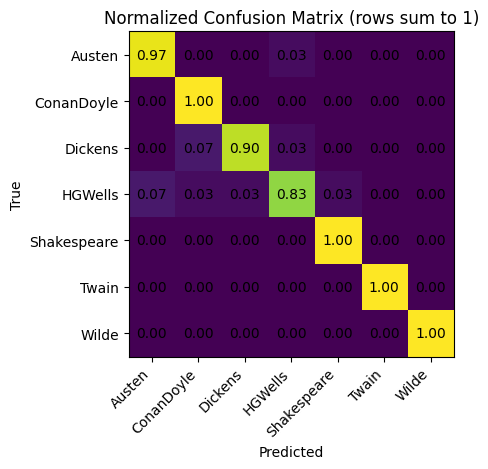

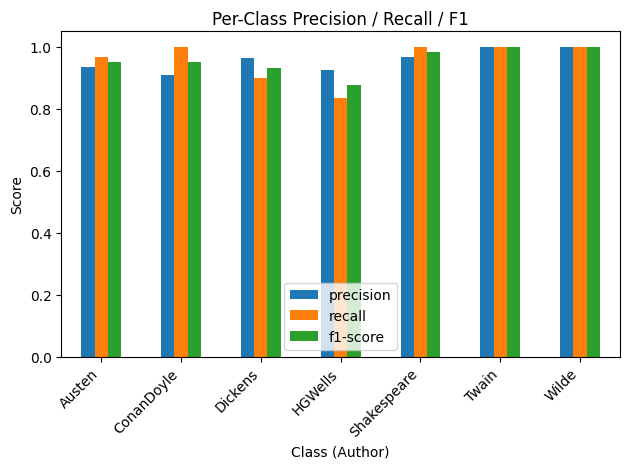

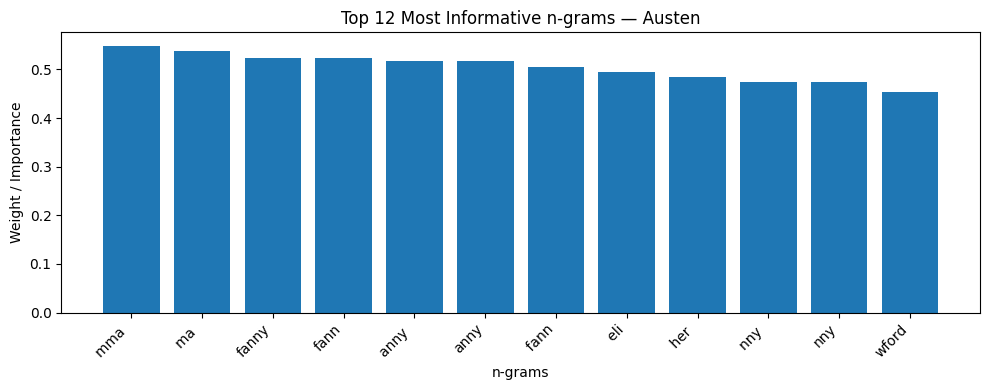

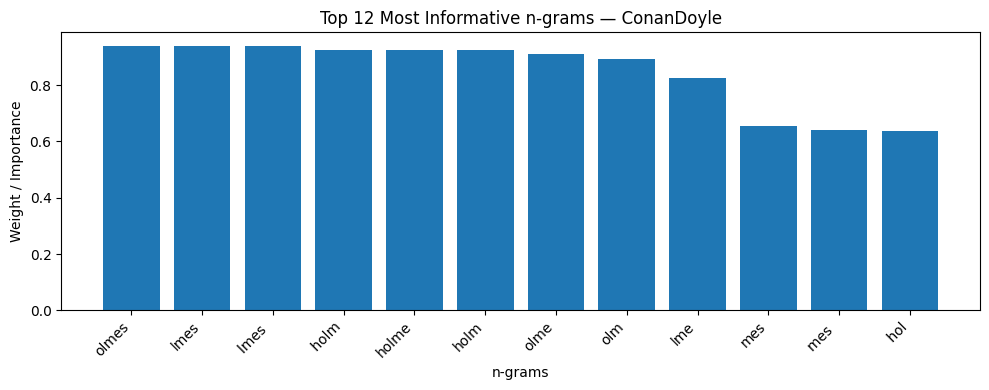

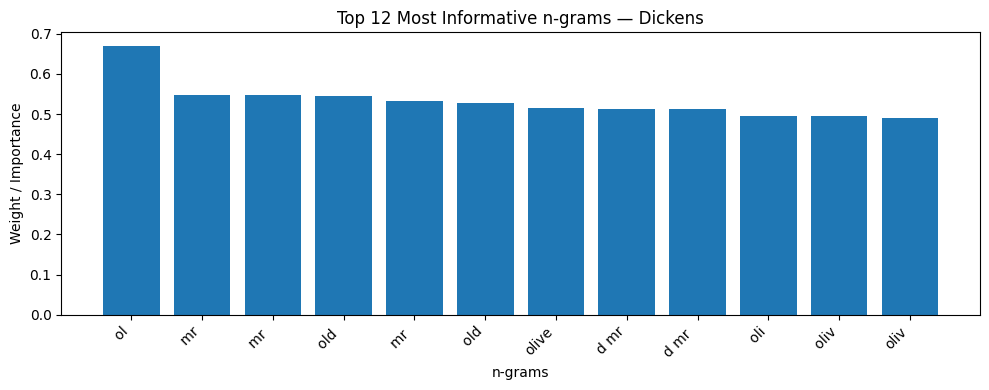

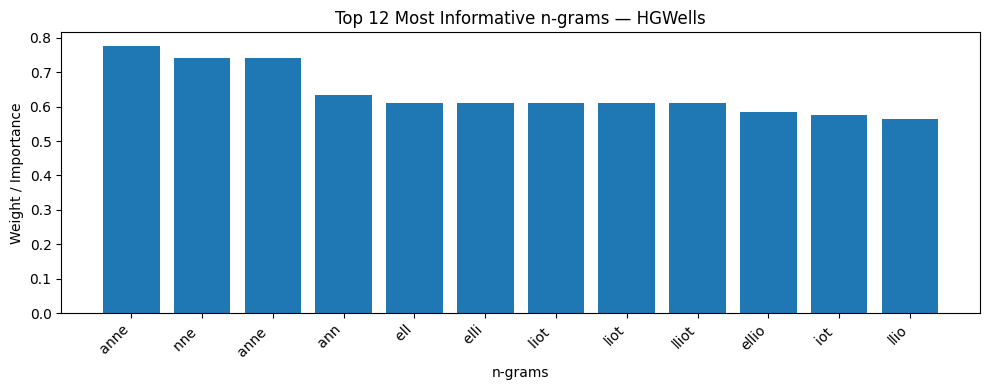

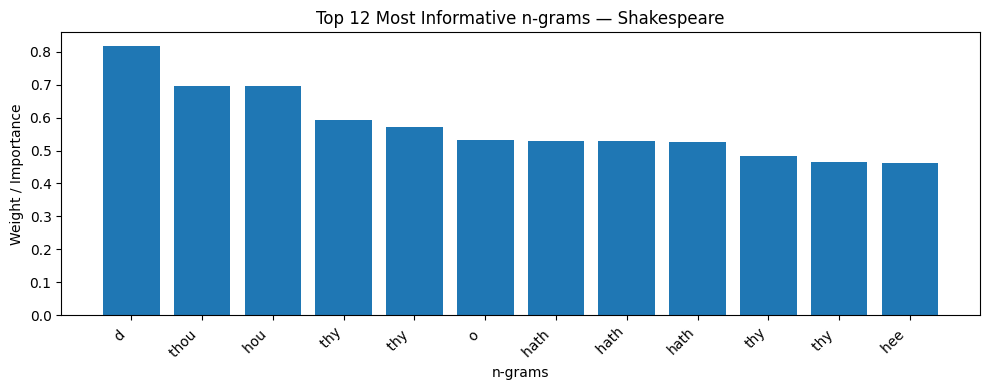

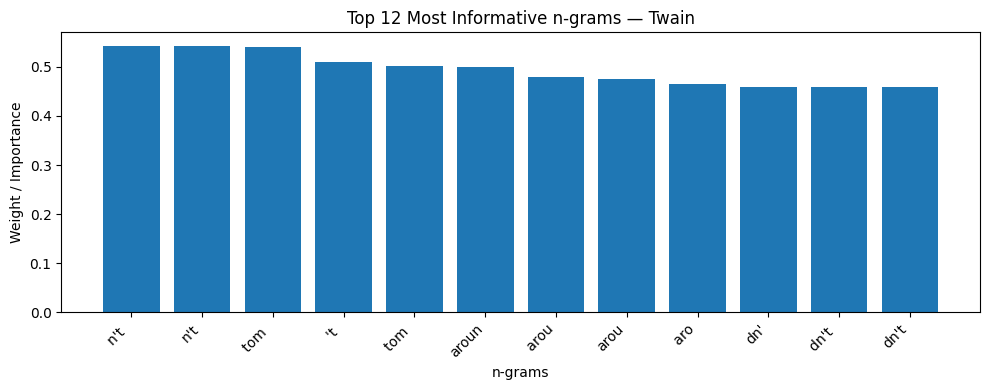

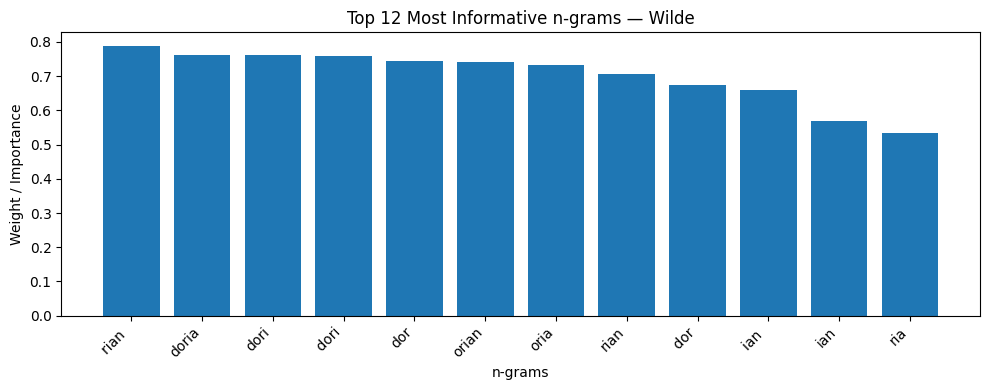

Visualizations complete: normalized confusion matrix, per-class metrics, and top n-grams per author.


In [ ]:
# ===========================
# RESULT VISUALIZATION + TOP FEATURES (FINAL TOUCH)
# ---------------------------
# What this cell does:
# 1) Plots a normalized confusion matrix for the test set.
# 2) Plots per-class precision/recall/F1 as bars.
# 3) Extracts and plots the top N most-informative n-grams per author/class
#    from the best trained pipeline (supports LinearSVC, LogisticRegression/SGD, MultinomialNB).
#
# Requirements:
# - Variables defined earlier: best_model (pipeline), y_test, and TE (test texts; TE=X_test or X_test_proc)
# - Imports available: numpy as np, pandas as pd, matplotlib.pyplot as plt
# - From sklearn: classification_report, confusion_matrix
# ===========================

# ------------- safety checks & predictions
if 'best_model' not in globals():
    raise RuntimeError("best_model not found. Run your model selection/evaluation cells first.")

if 'TE' not in globals():
    # fall back to X_test if TE (processed test texts) isn't defined
    TE = X_test

y_pred = best_model.predict(TE)
classes = list(getattr(best_model.named_steps['clf'], 'classes_', sorted(pd.unique(y_test))))

# ------------- 1) Normalized confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=classes)
cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)

fig, ax = plt.subplots()
ax.imshow(cm_norm)  # default colormap; no explicit colors
ax.set_title("Normalized Confusion Matrix (rows sum to 1)")
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.set_xticks(np.arange(len(classes)))
ax.set_yticks(np.arange(len(classes)))
ax.set_xticklabels(classes, rotation=45, ha="right")
ax.set_yticklabels(classes)
for i in range(len(classes)):
    for j in range(len(classes)):
        val = cm_norm[i, j]
        ax.text(j, i, f"{val:.2f}", ha="center", va="center")
fig.tight_layout()
plt.show()

# ------------- 2) Per-class precision / recall / F1 bars
rep = classification_report(y_test, y_pred, labels=classes, output_dict=True, zero_division=0)
per_class = pd.DataFrame({c: rep.get(c, {}) for c in classes}).T[["precision", "recall", "f1-score"]]

ax = per_class.plot(kind="bar")
ax.set_title("Per-Class Precision / Recall / F1")
ax.set_xlabel("Class (Author)")
ax.set_ylabel("Score")
plt.xticks(rotation=45, ha="right")
plt.legend(loc="best")
plt.tight_layout()
plt.show()

# ------------- 3) Top-N features per class (n-grams)
def extract_top_features_from_pipeline(pipeline, top_k=15):
    vect = pipeline.named_steps['vect']
    clf  = pipeline.named_steps['clf']
    feature_names = np.array(vect.get_feature_names_out())

    # Determine class-feature weights matrix
    if hasattr(clf, "coef_"):  # LinearSVC, LogisticRegression, SGDClassifier (linear)
        weights = clf.coef_
    elif hasattr(clf, "feature_log_prob_"):  # MultinomialNB
        weights = clf.feature_log_prob_
    else:
        raise TypeError("Unsupported classifier for feature introspection.")

    class_labels = list(getattr(clf, "classes_", []))
    if not class_labels:
        raise RuntimeError("Classifier classes_ not found.")

    # For each class, pick top positive-weight features
    top = {}
    for i, label in enumerate(class_labels):
        w = weights[i]
        top_idx = np.argsort(w)[-top_k:][::-1]
        top[label] = (feature_names[top_idx], w[top_idx])
    return top

# You can limit which classes to plot by setting SELECT_LABELS to a subset (e.g., ["Shakespeare","Austen"])
SELECT_LABELS = None        # or e.g., ["Shakespeare","Austen"]
TOP_K = 12                  # number of n-grams to show per class

top_feats = extract_top_features_from_pipeline(best_model, top_k=TOP_K)

labels_to_plot = SELECT_LABELS if SELECT_LABELS else classes
for label in labels_to_plot:
    feats, weights = top_feats[label]
    # Bar plot (vertical) of top features
    fig, ax = plt.subplots(figsize=(10, 4))
    ax.bar(np.arange(len(feats)), weights)  # default colors
    ax.set_title(f"Top {TOP_K} Most Informative n-grams — {label}")
    ax.set_xlabel("n-grams")
    ax.set_ylabel("Weight / Importance")
    ax.set_xticks(np.arange(len(feats)))
    ax.set_xticklabels(feats, rotation=45, ha="right")
    fig.tight_layout()
    plt.show()

print("Visualizations complete: normalized confusion matrix, per-class metrics, and top n-grams per author.")


In [ ]:
# ===========================
# CELL 9: UNSEEN TEXT PREDICTIONS
# ---------------------------
# What this cell does:
# - Feeds a few handcrafted/unseen excerpts into the best model.
# - Prints the predicted author for each snippet.
#
# Why this matters:
# - Demonstrates real-world usability beyond the test set.
#
# What to look for:
# - Reasonable author predictions consistent with the style of each sample.
# ===========================


samples = [
    "O Romeo, Romeo! wherefore art thou Romeo? I take thee at thy word.",
    "My dear sir, your proposal, though unexpected, cannot be uncontemplated.",
    "The street, thick with fog and haste, gave way to the clerk's modest hopes.",
]

preds = best_model.predict(samples)
for s, p in zip(samples, preds):
    print(f"Author: {p}\nText: {s}\n")


Author: Shakespeare
Text: O Romeo, Romeo! wherefore art thou Romeo? I take thee at thy word.

Author: Shakespeare
Text: My dear sir, your proposal, though unexpected, cannot be uncontemplated.

Author: Shakespeare
Text: The street, thick with fog and haste, gave way to the clerk's modest hopes.



In [ ]:
# ===========================
# CELL 10: SAVE TRAINED PIPELINE (OPTIONAL)
# ---------------------------
# What this cell does:
# - Serializes the best end-to-end pipeline (vectorizer + classifier) to disk via pickle.
# - Lets you reload and reuse the model without retraining.
#
# What to look for:
# - A confirmation path printed (e.g., /content/best_author_id_model.pkl).
# - The file appears in the Colab file browser for download.
# ===========================


import pickle

MODEL_PATH = "/content/best_author_id_model.pkl"
with open(MODEL_PATH, "wb") as f:
    pickle.dump(best_model, f)

print(f"Saved trained pipeline to {MODEL_PATH}")


Saved trained pipeline to /content/best_author_id_model.pkl
